In [1]:
import numpy as np
import ar1_approx as ar1
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as opt
import scipy
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from LinApp_FindSS import LinApp_FindSS
%matplotlib inline

**Exercise 1**

In [2]:
# Calibration

α = 0.35
β = 0.98
A = α * β
kbar = A ** (1 / (1 - α))
ρ = 0.95
σ = 0.02

The Uhlig matices are defined as follows:
<br>
$F=\frac{\alpha\bar{K}^{\alpha - 1}}{\bar{K}^\alpha - \bar{K}}$
<br>
$G = -\frac{\alpha\bar{K}^{\alpha - 1}(\alpha+\bar{K}^{\alpha - 1})}{\bar{K}^\alpha - \bar{K}}$
<br>
$H = \frac{\alpha^2\bar{K}^{2(\alpha-1)}}{\bar{K}^\alpha - \bar{K}}$
<br>
$L = -\frac{\alpha\bar{K}^{2\alpha-1}}{\bar{K}^\alpha - \bar{K}}$
<br>
$M = \frac{\alpha^2\bar{K}^{2(\alpha-1)}}{\bar{K}^\alpha - \bar{K}}$

In [3]:
# Define Uhlig matrices

denom = kbar ** α - kbar

F = (α * kbar ** (α - 1) ) / denom
G = -(α * kbar ** (α - 1) * (α + kbar ** (α - 1))) / denom
H = (α ** 2 * kbar ** (2 * (α - 1))) / denom
L = -(α * kbar ** (2 * α - 1)) / denom
M = (α ** 2 * kbar ** (2 * (α - 1))) / denom

In [4]:
def uhlig(F, G, H, L, M):
    print("F = ", F)
    print("G = ", G)
    print("H = ", H)
    print("L = ", L)
    print("M = ", M)

In [5]:
uhlig(F, G, H, L, M)

F =  2.763343017362853
G =  -9.023563692703393
H =  2.8197377728192374
L =  -1.5531326685925513
M =  2.8197377728192374


$P$ and $Q$ are defined as follows:
<br>
$P = \frac{-G \pm \sqrt[]{G^2-4FH}}{2F}$
<br>
$Q = -\frac{LN + M}{FN + FP + G}$

In [6]:
# Define P and Q using Uhlig matrices

N = ρ

P = (-G - np.sqrt(G ** 2 - 4 * F * H)) / (2 * F)
Q = -(L * N + M) / (F * N + F * P + G)

In [7]:
def scalar_vals(P, Q):
    print("P = ", P)
    print("Q = ", Q)

In [8]:
scalar_vals(P, Q)

P =  0.35
Q =  0.24750650674493596


In [9]:
# Create K and z grids
K_t_grid = np.linspace(1.5, 10)
z_grid = np.linspace(-1, 1)

# Create a meshgrid
K_t, z = np.meshgrid(K_t_grid, z_grid)

# Calculate K_prime across the grid
K_prime = lambda K, Z: K + P * (K_t - K) + Q * z

y = K_prime(K_t, z)

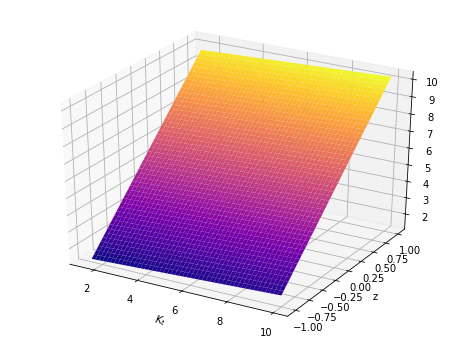

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_t, z, y.T, cmap='plasma')
ax.set(xlabel='$K_t$', ylabel='z')
plt.show()

In [11]:
# Find matrix derivatives

alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02

params = (alpha, beta, rho, sigma)

Zbar = np.array([0.])
nx = 1
ny = 0
nz = 1
logX = 0 
Sylv = 0

kbar = (alpha*beta)**(1/(1-alpha))
kgrid = np.linspace(0.5*kbar, 1.5*kbar, 25)
sizek = len(kgrid)

pi, zgrid = ar1.rouwen(rho, mu = 0, step = (10/25*sigma), num = 25)
sizez = len(zgrid)

In [12]:
def Modeldyn(theta0, params):
    
    (Xpp, Xp, X, Zp, Z) = theta0
    alpha, beta, rho, sigma = params
    E1 = 1/(np.exp(Z) * X ** alpha - Xp) \
        - beta * ((alpha * np.exp(Zp) * Xp ** (alpha - 1))/ 
        (np.exp(Zp) * Xp ** alpha - Xpp))
                                                                            
    return E1

In [13]:
guessK = np.array([.1])

# find the steady state
kbar = LinApp_FindSS(Modeldyn, params, guessK, Zbar, nx, 0)[0]
print ('Kbar: ', kbar)

# check steady state
theta0 = np.array([kbar, kbar, kbar, 0., 0.])
check = Modeldyn(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

Kbar:  0.19278261945042247
check:  -4.440892098500626e-16


In [14]:
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn, params, theta0, nx, 0, nz, logX)
NN = rho
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)
print('NN: ', NN)

PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)

FF:  [[-7.33367648]]
GG:  [[23.9477678]]
HH:  [[-7.48334336]]
LL:  [[1.41380536]]
MM:  [[-4.12188152]]
NN:  0.95
PP: [[0.35]]
QQ [[0.19278262]]


In [15]:
linPF = np.ones((sizek,sizez))
for i in range(sizez):
    linPF[:, i] = kbar + PP*(kgrid - kbar) + QQ*zgrid[i]

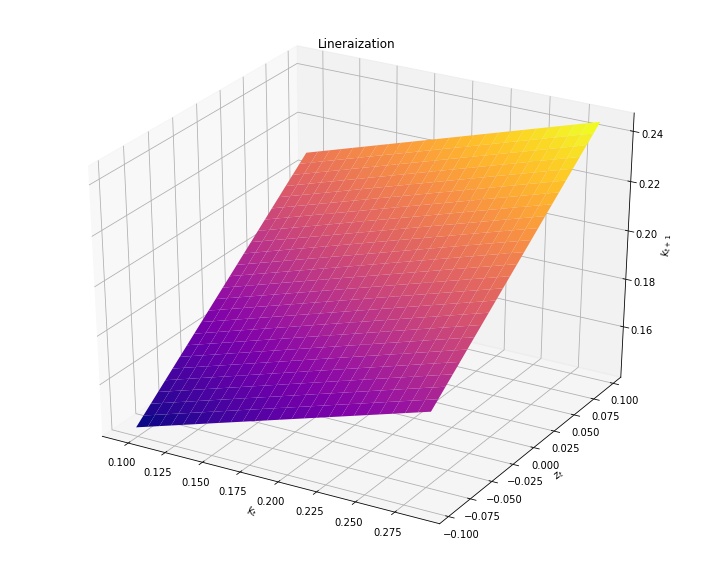

In [16]:
k, z = np.meshgrid(kgrid,zgrid)
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection="3d")
ax.plot_surface(k, z, linPF, cmap="plasma")
ax.set_xlabel("$k_t$")
ax.set_ylabel("$z_t$")
ax.set_zlabel("$k_{t+1}$")
plt.title("Lineraization")
plt.tight_layout()
plt.show()

**Exercise 2**

In [17]:
logX = 1
Sylv = 0

In [18]:
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn, params, theta0, nx, 0, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)

FF:  [[-1.41380536]]
GG:  [[4.61671341]]
HH:  [[-1.44265853]]
LL:  [[1.41380536]]
MM:  [[-4.12188152]]
PP: [[0.35]]
QQ [[1.]]


In [19]:
log_linPF = np.ones((sizek,sizez))
for i in range(sizez):
    log_linPF[:, i] = kbar + (PP*(kgrid - kbar)/kbar + QQ*zgrid[i])*kbar

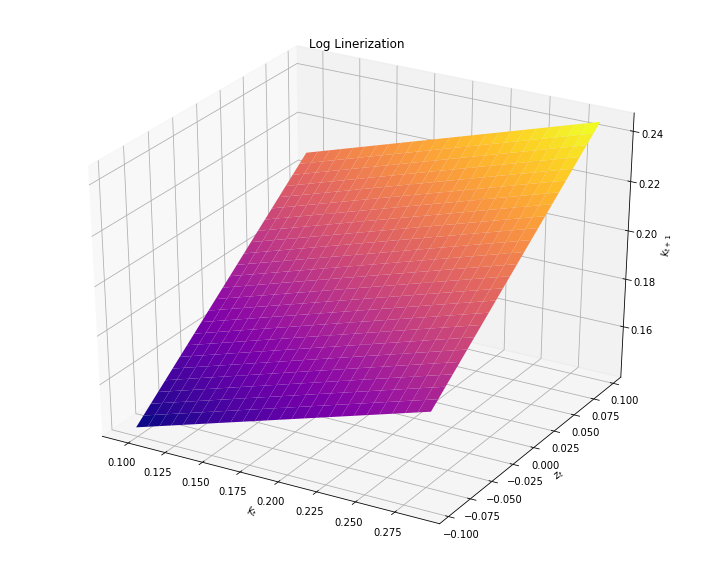

In [20]:
k, z = np.meshgrid(kgrid,zgrid)
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection="3d")
ax.plot_surface(k, z, log_linPF, cmap="plasma")
ax.set_xlabel("$k_t$")
ax.set_ylabel("$z_t$")
ax.set_zlabel("$k_{t+1}$")
plt.title("Log Linerization")
plt.tight_layout()
plt.show()

**Exercise 3**

We will use the following in our calculation:

(Equation 5)<br>
$E_t\{F\tilde{X}_{t+1} + G\tilde{X}_{t}+H\tilde{X}_{t-1}+L\tilde{Z}_{t+1}+M\tilde{Z}_t\} = 0$
<br>
<br>
(Equation 6)<br>
$\tilde{Z}_t = N\tilde{Z}_{t-1}+\varepsilon_t$
<br>
<br>
(Equation 7)<br>
$\tilde{X}_t=P\tilde{X}_{t-1}+Q\tilde{Z}_t$
<br>
<br>
Observe that

$0 = E_t\{F\tilde{X}_{t+1} + G\tilde{X}_{t}+H\tilde{X}_{t-1}+L\tilde{Z}_{t+1}+M\tilde{Z}_t\}$
&nbsp;&nbsp; $= E_t\{F(P\tilde{X}_t+Q\tilde{Z}_{t+1}) + G(P\tilde{X}_{t-1}+Q\tilde{Z}_t)+H\tilde{X}_{t-1}+L(N\tilde{Z}_t+\varepsilon_{t+1})+M\tilde{Z}_t\}$
&nbsp;&nbsp; $= E_t\{F(P(P\tilde{X}_{t-1}+Q\tilde{Z}_{t})+Q\tilde{Z}_{t+1}) + GP\tilde{X}_{t-1}+GQ\tilde{Z}_t+H\tilde{X}_{t-1}+LN\tilde{Z}_t+L\varepsilon_{t+1}+M\tilde{Z}_t\}$
&nbsp;&nbsp; $= E_t\{FP^2\tilde{X}_{t-1}+FPQ\tilde{Z}_{t}+FQ\tilde{Z}_{t+1} + GP\tilde{X}_{t-1}+GQ\tilde{Z}_t+H\tilde{X}_{t-1}+LN\tilde{Z}_t+L\varepsilon_{t+1}+M\tilde{Z}_t\}$
$= E_t\{FP^2\tilde{X}_{t-1}+FPQ\tilde{Z}_{t}+FQN\tilde{Z}_t+FQ\varepsilon_t + GP\tilde{X}_{t-1}+GQ\tilde{Z}_t+H\tilde{X}_{t-1}+LN\tilde{Z}_t+L\varepsilon_{t+1}+M\tilde{Z}_t\}$
$= [FP^2\tilde{X}_{t-1}+FPQ\tilde{Z}_{t}+FQN\tilde{Z}_t + GP\tilde{X}_{t-1}+GQ\tilde{Z}_t+H\tilde{X}_{t-1}+LN\tilde{Z}_t+M\tilde{Z}_t]$
$= [(FP^2+GP+H)\tilde{X}_{t-1}+(FPQ+FQN+GQ+LN+M)\tilde{Z}_{t}]$
$= [((FP+G)P+H)\tilde{X}_{t-1}+((FQ+L)N+(FP+G)Q+M)\tilde{Z}_{t}]$
$= \boxed{[(FP+G)P+H]\tilde{X}_{t-1}+[(FQ+L)N+(FP+G)Q+M]\tilde{Z}_{t}}$

**Exercise 4**

In [21]:
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
zbar = 0
rho = 0.9
tau = 0.05

# make parameter list to pass to functions
params = (delta, tau, zbar, alpha, gamma, xi, beta, a)

# set LinApp parameters
Zbar = np.array([0.])
nx = 1
ny = 1
nz = 1
logX = 1
Sylv = 1

In [22]:
def Modeldefs(Xp, X, Y, Z, params):
    
    kp = Xp
    k = X
    l = Y
    z = Z
    
    delta, tau, zbar, alpha, gamma, xi, beta, a = params
    
    Y = k**alpha * (np.exp(z)*l)**(1-alpha)
    w = (1-alpha)* Y/l
    r = alpha*Y/k
    c = (w*l + (r - delta)*k) + k - kp
    u = (c**(1-gamma)-1)/(1-gamma) + a*(((1-l)**(1-xi))-1)/(1-xi)
    
    return Y, w, r, c, u

In [23]:
def Modeldyn(theta0, params):

    # unpack theat0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    l = Y
    
    # find definitions for now and next period
    Y, w, r, c, u = Modeldefs(Xp, X, Y, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    delta, tau, zbar, alpha, gamma, xi, beta, a = params
    E1 = c**(-gamma) - beta* cp**(-gamma) * ((1 - tau)*(rp - delta) + 1)
    E2 = a * (1-l)**(-xi) - w * (1 - tau) * c**(-gamma)
    
    return np.array([E1, E2])

In [24]:
## take a guess for steady state values of k and ell
guessXY = np.array([.1, .25])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

Ybar, wbar, rbar, cbar, ubar = Modeldefs(kbar, kbar, ellbar, 0, params)
Tbar = tau*cbar
ibar = delta*kbar
print ('Ybar: ', Ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('lbar: ', ellbar)
print ('ubar: ', ubar)
print ('Tbar: ', Tbar)
print ('ibar: ', ibar)

XYbar:  [4.22522903 0.57979145]
check:  [-6.43929354e-15 -2.02060590e-14]
Ybar:  1.2832261088325483
wbar:  1.327952768351271
rbar:  0.12148227712137966
cbar:  0.8607032061541906
lbar:  0.5797914531670038
ubar:  -0.7108726381177776
Tbar:  0.043035160307709534
ibar:  0.42252290267835735


**Exercise 5** 

In [25]:
epsilon = 1e-4
params = np.array([delta, tau, zbar, alpha, gamma, xi, beta, a])
deriv_plus = np.zeros((8,8))
deriv_min = np.zeros((8,8))

for i in range(8):
    params_plus = params.copy()
    params_plus[i] = params[i] + epsilon
    delta = params_plus[0]
    tau = params_plus[1]
    Zbar = np.array([params_plus[2]])
    kbar_d, lbar_d = LinApp_FindSS(Modeldyn, params_plus, guessXY, Zbar, nx, ny)
    y_d, w_d, r_d, c_d, u_d = Modeldefs(kbar_d, kbar_d, lbar_d, 0, params_plus)
    t_d = tau*c_d 
    i_d = delta*kbar_d
    deriv_plus[:,i] = np.array([kbar_d, c_d, r_d, w_d, lbar_d, t_d, y_d, i_d])
        
for i in range(8):
    params_min = params.copy()
    params_min[i] = params[i] - epsilon
    delta = params_min[0]
    tau = params_min[1]
    Zbar = np.array([params_min[2]])
    kbar_d, lbar_d = LinApp_FindSS(Modeldyn, params_min, guessXY, Zbar, nx, ny)
    y_d, w_d, r_d, c_d, u_d = Modeldefs(kbar_d, kbar_d, lbar_d, 0, params_min)
    t_d = tau*c_d 
    i_d = delta*kbar_d
    deriv_min[:,i] = np.array([kbar_d, c_d, r_d, w_d, lbar_d, t_d, y_d, i_d])
        
deriv  = (deriv_plus - deriv_min)/(2*epsilon)
print(deriv)

[[-4.83498828e+01 -2.32322539e+00  2.83828800e+00  2.59848984e+01
   1.38699228e-01 -8.01655755e-01  6.54305400e+01 -1.84925473e+00]
 [-3.51129599e+00 -2.34392288e-01 -1.91760243e-01  2.08520605e+00
   2.82538223e-02 -1.63301841e-01  1.75106072e+00 -3.76703716e-01]
 [ 1.00000000e+00  2.26129235e-02 -7.28893663e-02  9.02056208e-13
  -3.95516953e-12 -2.77555756e-12 -1.09603456e+00  2.28983499e-12]
 [-7.28750161e+00 -1.64791633e-01  5.31181107e-01  4.39587904e+00
   2.88657986e-11  1.99840144e-11  7.98735319e+00 -1.66533454e-11]
 [ 1.31977556e+00 -1.38923703e-01 -1.90317862e-01 -7.69380980e-01
   1.90324894e-02 -1.10004251e-01  2.60151391e-01 -2.53757153e-01]
 [-1.75564799e-01  8.48983590e-01 -9.58801215e-03  1.04260303e-01
   1.41269112e-03 -8.16509205e-03  8.75530361e-02 -1.88351858e-02]
 [-4.12105068e+00 -4.66714827e-01  9.20685564e-02  4.68369589e+00
   4.21237451e-02 -2.43467417e-01  8.29411472e+00 -5.61629190e-01]
 [-6.09754689e-01 -2.32322539e-01  2.83828800e-01  2.59848984e+00
   

**Exercise 6**

In [26]:
nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 1

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, ellbar, 0., 0.])

In [27]:
def Modeldyn(theta0, params):

    # unpack theta0
    (kpp, kp, k, lp, l, ll, Zp, Z) = theta0
    
    # unpacking parameters
    delta, tau, zbar, alpha, gamma, xi, beta, a = params
    
    # find definitions for now and next period
    Y, w, r, c, u = Modeldefs(kp, k, l, Z, params)
    Yp, wp, rp, cp, up = Modeldefs(kpp, kp, lp, Zp, params)
    
    # Evaluate Euler equations
    E1 = c**(-gamma) - beta*cp**(-gamma)*((1 - tau)*(rp - delta) + 1)
    E2 = a*(1 - l)**(-xi) - w*(1 - tau)*c**(-gamma)
    
    return np.array([E1, E2])

In [28]:
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn, params, theta0, nx, ny, nz, logX)
np.set_printoptions(suppress=False)
np.set_printoptions(precision=6)

print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

FF:  [[-17.856786  36.195913]
 [  0.       -22.52732 ]]
GG:  [[-18.24039    3.155187]
 [ 22.277027   0.      ]]
HH:  [[-3.253925  0.      ]
 [ 8.63825   0.      ]]
LL:  [[3.155187]
 [0.      ]]
MM:  [[-3.253925]
 [ 3.003659]]


**Exercise 7**

In [29]:
# Parameters
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.4
a = 0.5
delta = 0.10
zbar = 0
rho = 0.9
tau = 0.05
sigma = 0.02
simulations = 10000
periods = 250
PP = np.array([[0.915294, 0], [-0.191927,0]])
QQ = np.array( [[ 0.128997],[-0.01131]])

In [30]:
gdp = np.zeros((simulations, periods))
labor = np.zeros((simulations, periods))
invest = np.zeros((simulations, periods))
consum = np.zeros((simulations, periods))

for i in range(simulations):
    Z = np.zeros((periods+1))
    K = np.zeros((periods+1))
    L = np.zeros((periods+1))
    e_z = np.random.normal(0, scale = sigma, size=(periods + 1))
    for j in range(1, periods+1):
        Z[j] = NN * Z[j - 1] + e_z[j]
        K[j] = PP[0, 0] * K[j - 1] + QQ[0, 0] * Z[j] 
        L[j] = PP[1, 0] * L[j - 1] + QQ[1, 0] * Z[j]

    K = kbar * np.exp(K)
    L = ellbar * np.exp(L)

    Z = Z[:-1]
    I = K[:-1] - (1 - delta)*K[1:]
    K = K[:-1]
    L = L[:-1]
    Y = (K**alpha) * (((np.exp(Z)*L)**(1 - alpha)))
    W = (1 - alpha)* np.exp(Z)**(1 - alpha) * (K**alpha) * (L**(-alpha))
    R = alpha*((L*np.exp(Z))**(1 - alpha))* K**(alpha - 1)
    C  = W*L + (R - delta) * K - I
    
    gdp[i,:] = Y
    labor[i,:] = L
    invest[i,:] = I
    consum[i,:] = C

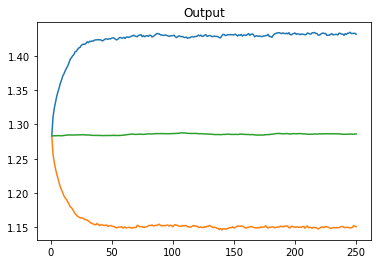

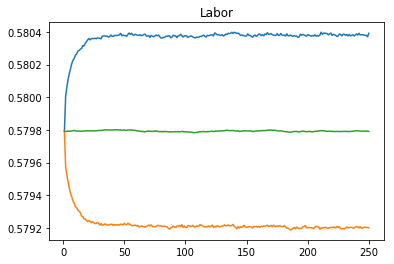

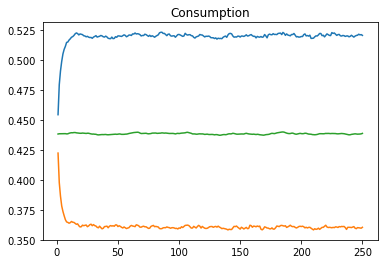

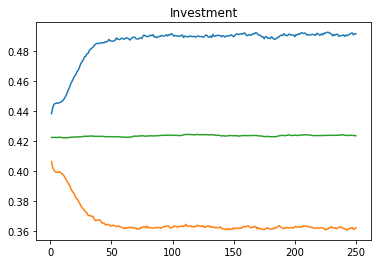

In [31]:
x = np.linspace(1,250,250)

conf95 = np.percentile(gdp, 95, axis=0)
conf5 = np.percentile(gdp, 5, axis=0)
mean = np.mean(gdp, axis=0)
plt.plot(x, conf95)
plt.plot(x, conf5)
plt.plot(x, mean)
plt.title("Output")
plt.show()

conf95 = np.percentile(labor, 95, axis=0)
conf5 = np.percentile(labor, 5, axis=0)
mean = np.mean(labor, axis=0)
plt.plot(x, conf95)
plt.plot(x, conf5)
plt.plot(x, mean)
plt.title("Labor")
plt.show()

conf95 = np.percentile(consum, 95, axis=0)
conf5 = np.percentile(consum, 5, axis=0)
mean = np.mean(consum, axis=0)
plt.plot(x, conf95)
plt.plot(x, conf5)
plt.plot(x, mean)
plt.title("Consumption")
plt.show()

conf95 = np.percentile(invest, 95, axis=0)
conf5 = np.percentile(invest, 5, axis=0)
mean = np.mean(invest, axis=0)
plt.plot(x, conf95)
plt.plot(x, conf5)
plt.plot(x, mean)
plt.title("Investment")
plt.show()

**Exercise 8**

In [32]:
name = ["Output", "Labor", "Consumption", "Investment"]
data = [gdp, labor, consum, invest]
for i in range(len(data)): 
    mean = data[i].mean(axis = 1)
    vol = data[i].std(axis = 1)
    var = mean / vol
    rel_vol = vol / data[0].std(axis = 1)
    persis = np.corrcoef(data[i][0][:-1],data[i][0][1:])
    cycl = np.corrcoef(data[i][0],data[0][0])
    print(name[i])
    print("Mean:", np.mean(mean))
    print("Error:", scipy.stats.sem(mean))
    print("Volatility:", np.mean(vol))
    print("Error:",scipy.stats.sem(vol))
    print("Coef of Variation:", np.mean(var))
    print("Error:",scipy.stats.sem(var))
    print("Rel Variation:", np.mean(rel_vol))
    print("Error:",scipy.stats.sem(rel_vol))
    print("Persistance:", np.mean(persis))
    print("Cyclicality:", np.mean(cycl))
    print("\n")

Output
Mean: 1.285576720020144
Error: 0.0003604701157873908
Volatility: 0.07180170153861327
Error: 0.00017142443605156158
Coef of Variation: 18.910520681780852
Error: 0.04463300985847383
Rel Variation: 1.0
Error: 0.0
Persistance: 0.9851936442570363
Cyclicality: 0.9999999999999998


Labor
Mean: 0.579792515683002
Error: 1.3033555161218646e-06
Volatility: 0.0003186614874511876
Error: 5.800673590851171e-07
Coef of Variation: 1878.572769632497
Error: 3.345428550432801
Rel Variation: 0.004502165874298367
Error: 3.285634405744595e-06
Persistance: 0.9579958648722939
Cyclicality: 0.027423697576298978


Consumption
Mean: 0.438469416504539
Error: 7.252839268338666e-05
Volatility: 0.0472418599731896
Error: 6.290786156331277e-05
Coef of Variation: 9.441335734697017
Error: 0.012313465879946766
Rel Variation: 0.6798575645890463
Error: 0.001122647869100103
Persistance: 0.9706192798453095
Cyclicality: 0.8197307424988929


Investment
Mean: 0.4235309978884192
Error: 0.00014538376188414427
Volatility: 0.0

**Exercise 9**

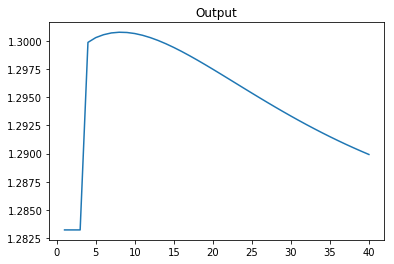

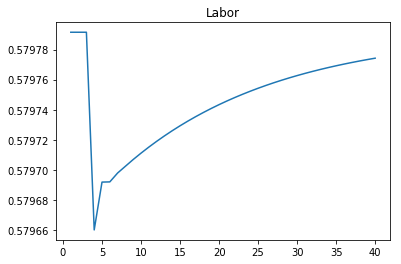

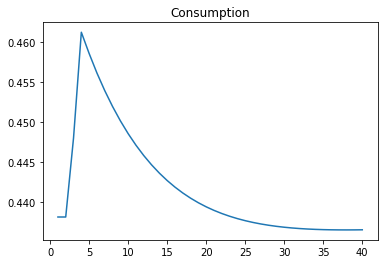

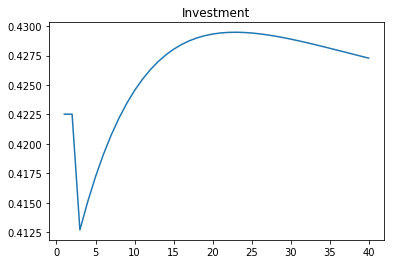

In [33]:
periods = 40
Z = np.zeros((periods+1))
K = np.zeros((periods+1))
L = np.zeros((periods+1))
e_z = np.zeros((periods+1))
e_z[3] = sigma
for j in range(1, periods+1):
    Z[j] = NN * Z[j - 1] + e_z[j]
    K[j] = PP[0, 0] * K[j - 1] + QQ[0, 0] * Z[j] 
    L[j] = PP[1, 0] * L[j - 1] + QQ[1, 0] * Z[j]

K = kbar * np.exp(K)
L = ellbar * np.exp(L)
Z = Z[:-1]
I = K[:-1] - (1 - delta)*K[1:]
K = K[:-1]
L = L[:-1]
Y = (K**alpha) * (((np.exp(Z)*L)**(1 - alpha)))
W = (1 - alpha)* np.exp(Z)**(1 - alpha) * (K**alpha) * (L**(-alpha))
R = alpha*((L*np.exp(Z))**(1 - alpha))* K**(alpha - 1)
C  = W*L + (R - delta) * K - I

data = np.array([Y,L,C,I])
name = np.array(["Output","Labor", "Consumption", "Investment"])
for i in range(len(data)):
    x = np.linspace(1,periods, periods)
    plt.plot(x, data[i])
    plt.title(name[i])
    plt.show()

**Exercise 10**

In [34]:
yrs_lived = 60
S = 3
nvec = np.array([1.0, 1.0, 0.2])
beta_annual = 0.96
beta = beta_annual ** (yrs_lived / S)
sigma = 3

alpha = 0.35
A = 1.0
delta_annual = 0.05
delta =  1 - (1-delta_annual) ** (yrs_lived / S)

T = int(round(10*S))
TPI_tol = 1e-13

labor = np.array([1,1,0.2])
delta = 0.6415
alpha = 0.35

periods = 3
beta = 0.442
sigma = 3.0
A = 1.0
zbar = 0 

T = 10*periods

nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 0
Zbar = np.array([0.])

params = (alpha, beta, nvec, delta, sigma)
yrs_lived = 60
S = 3
nvec = np.array([1.0, 1.0, 0.2])
beta_annual = 0.96
beta = beta_annual ** (yrs_lived / S)
sigma = 3

alpha = 0.35
A = 1.0
delta_annual = 0.05
delta =  1 - (1-delta_annual) ** (yrs_lived / S)

T = int(round(10*S))
TPI_tol = 1e-13

labor = np.array([1,1,0.2])
delta = 0.6415
alpha = 0.35

periods = 3
beta = 0.442
sigma = 3.0
A = 1.0
zbar = 0 

T = 10*periods

nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 0
Zbar = np.array([0.])

params = (alpha, beta, nvec, delta, sigma)

In [35]:
def get_r(K, L, z):
    r = alpha * np.exp(z) * ((L/K) ** (1 - alpha)) - delta
    return r

def get_w(K, L, z):
    return (1 - alpha) * np.exp(z) * ((K / L) ** alpha)

def get_K(bvec):
    return bvec.sum()

def get_Y(K, L, z):
    return A * (K ** alpha) * (L ** (1 - alpha))

def get_L(nvec):
    return nvec.sum()

def get_c(bt, btp1, r, w, n):
    c = (1 + r) * bt + w * n - btp1
    return c

def get_Csum(cvec):
    return cvec.sum()

def get_MU(c):
    MU_c = c ** (-sigma)
    return MU_c

In [36]:
def OLGModel(theta0, params):

    k2pp, k3pp, k2p, k3p, k2, k3, Zp, Z = theta0
    
    alpha, beta, nvec, delta, sigma = params
    
    bvec = np.array([k2, k3])
    bvecp = np.array([k2, k3])
    bvecpp = np.array([k2pp, k3pp])
    
    K = get_K(bvec)
    Kp = get_K(bvecp)
    Kpp = get_K(bvecpp)
    
    L = get_L(nvec)
    
    w = get_w(K, L, Z)
    wp = get_w(Kp, L, Zp)
    
    r = get_r(K, L, Z)
    rp = get_r(Kp, L, Zp)
    
    c1 = get_c(0, k2p, 0, w, nvec[0]) 
    c2 = get_c(k2, k3p, r, w, nvec[1])
    c2p = get_c(k2p, k3pp, rp, wp, nvec[1])
    c3p = get_c(k3p, 0, rp, wp, nvec[2])
    
    mu1 = get_MU(c1)
    mu2 = get_MU(c2)
    mu1p = get_MU(c2p)
    mu2p = get_MU(c3p)
    
    E1 = mu1 - beta * (1 + rp) * mu1p
    E2 = mu2 - beta * (1 + rp) * mu2p
    
    return np.array([E1, E2])

In [37]:
#K values
guessK = np.array([.1, .1])

# ss
XYbar= LinApp_FindSS(OLGModel, params, guessK, Zbar, nx, ny)
(k2bar, k3bar) = XYbar
print ('XXbar: ', XYbar)

theta0 = np.array([k2bar, k3bar, k2bar, k3bar, k2bar, k3bar, 0., 0.])

# check
check = OLGModel(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

XXbar:  [0.019313 0.058411]
check:  [-1.392664e-12  2.629008e-12]


In [38]:
theta0 = np.array([k2bar, k3bar, k2bar, k3bar, k2bar, k3bar, 0, 0])

[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(OLGModel, params, theta0, nx, ny, nz, logX)

print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)
    
NN = rho
    
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)

FF:  [[   0.       -137.731663]
 [   0.          0.      ]]
GG:  [[208.6655     0.      ]
 [  0.       361.938586]]
HH:  [[  -4.951139  -14.974809]
 [-134.160698  -94.161306]]
LL:  [[468.121027]
 [200.173448]]
MM:  [[-546.594687]
 [-405.737419]]
PP: [[0.115683 0.154156]
 [0.370673 0.260158]]
QQ [[1.426772]
 [0.623259]]


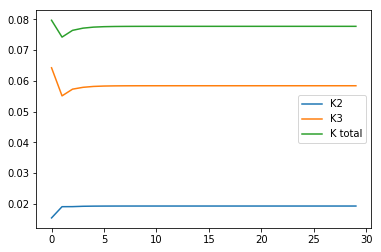

In [39]:
# K grid
K = np.zeros((2,T))
K[0,0] = np.log(0.8 * k2bar) - np.log(k2bar)
K[1,0] = np.log(1.1 * k3bar) - np.log(k3bar)
for i in range(1,T):
    K[:,i] = PP@K[:,i-1]
K[0,:] = k2bar * np.exp(K[0,:])    
K[1,:] = k3bar * np.exp(K[1,:])    
Ksum = K[0,:] + K[1,:]

x = np.linspace(0,T-1,T)
plt.plot(x, K[0,:], label="K2")
plt.plot(x, K[1,:], label="K3")
plt.plot(x, Ksum, label="K total")
plt.legend()
plt.show()

**Exercise 11**

In [40]:
periods = 40
gdp = np.zeros((simulations, periods))
invest = np.zeros((simulations, periods))
consum = np.zeros((simulations, periods))

for i in range(simulations):
    Z = np.zeros((periods+1))
    K = np.zeros((periods+1))
    logK = np.zeros((2,periods+1))
    e_z = np.random.normal(0, scale = sigma, size=(periods + 1))
    for j in range(1, periods+1):
        Z[j] = NN * Z[j - 1] + e_z[j]
        logK[:,j] = (PP@np.array([logK[:,j-1]]).T + QQ*Z[j]).T
    K2 = k2bar * np.exp(logK[0])
    K3 = k3bar * np.exp(logK[1])
    L = get_L(nvec)
    Z = Z[:-1]
    K = K2 + K3
    I = K[:-1] - (1 - delta)*K[1:]
    K = K[:-1]
    Y = (K**alpha) * (((np.exp(Z)*L)**(1 - alpha)))
    W = (1 - alpha)* np.exp(Z)**(1 - alpha) * (K**alpha) * (L**(-alpha))
    R = alpha*((L*np.exp(Z))**(1 - alpha))* K**(alpha - 1)
    C  = W*L + (R - delta) * K - I
    
    gdp[i,:] = Y
    invest[i,:] = I
    consum[i,:] = C

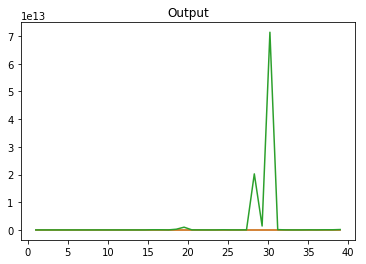

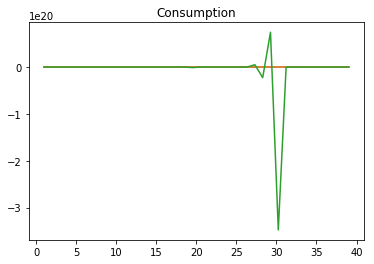

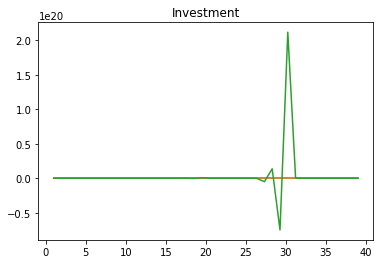

In [41]:
x = np.linspace(1,periods-1,periods)

conf95 = np.percentile(gdp, 95, axis=0)
conf5 = np.percentile(gdp, 5, axis=0)
mean = np.mean(gdp, axis=0)
plt.plot(x, conf95)
plt.plot(x, conf5)
plt.plot(x, mean)
plt.title("Output")
plt.show()

conf95 = np.percentile(consum, 95, axis=0)
conf5 = np.percentile(consum, 5, axis=0)
mean = np.mean(consum, axis=0)
plt.plot(x, conf95)
plt.plot(x, conf5)
plt.plot(x, mean)
plt.title("Consumption")
plt.show()

conf95 = np.percentile(invest, 95, axis=0)
conf5 = np.percentile(invest, 5, axis=0)
mean = np.mean(invest, axis=0)
plt.plot(x, conf95)
plt.plot(x, conf5)
plt.plot(x, mean)
plt.title("Investment")
plt.show()